In [173]:
import sidechainnet as scn

In [174]:
data_base_dirs = {
    "test":
    {
        "before":{
            "direc":"/ihome/dkoes/jok120/openfold/out/experiments/230320/validate_val_after_training/16_390/wandb/run-20230322_115143-3659ab3t",
            "csv":""
            },
        "after":{
            "direc":"/ihome/dkoes/jok120/openfold/out/experiments/230320/validate_val_after_training/16_390/wandb/run-20230322_114810-18trq0ov",
            "csv":""
            }
},
    "val":
    {
        "before":{
            "direc":"/ihome/dkoes/jok120/openfold/out/experiments/230320/validate_val_initial_training_b/wandb/run-20230320_211151-36cdbdde",
            "csv":""
            },
        # "after-earlier": {
        #     "direc":"/ihome/dkoes/jok120/openfold/out/experiments/230320/validate_val_after_training/40_942_1w4vxghv/wandb/run-20230321_231336-yi0kwfq5",
        #     "csv":""
        #     },
        "after": {
            "direc":"/ihome/dkoes/jok120/openfold/out/experiments/230320/validate_val_after_training/16_390/wandb/run-20230322_114130-2asi49hx",
            "csv":""
            }
    }
}

In [175]:
for split in ["val", "test"]:
    for version, dirpath_csv in data_base_dirs[split].items():
        dirpath = dirpath_csv["direc"]
        print(split, version, dirpath)
        # !mkdir -p ~/acs2023/evaluation_data/{split}/{version}
        # !scp  h2p:{dirpath}/files/val.csv ~/acs2023/evaluation_data/{split}/{version}/
        # !scp -r  h2p:{dirpath}/files/pdbs ~/acs2023/evaluation_data/{split}/{version}/
        data_base_dirs[split][version]["local-csv"] = f"~/acs2023/evaluation_data/{split}/{version}/val.csv"
        data_base_dirs[split][version]["local-pred-pdbs"] = f"~/acs2023/evaluation_data/{split}/{version}/pdbs"


val before /ihome/dkoes/jok120/openfold/out/experiments/230320/validate_val_initial_training_b/wandb/run-20230320_211151-36cdbdde
val after /ihome/dkoes/jok120/openfold/out/experiments/230320/validate_val_after_training/16_390/wandb/run-20230322_114130-2asi49hx
test before /ihome/dkoes/jok120/openfold/out/experiments/230320/validate_val_after_training/16_390/wandb/run-20230322_115143-3659ab3t
test after /ihome/dkoes/jok120/openfold/out/experiments/230320/validate_val_after_training/16_390/wandb/run-20230322_114810-18trq0ov


# Measure the OpenMM energy of the PDBs

In [88]:
import glob
import os
#import tqdm for notebooks
from tqdm.notebook import tqdm

In [91]:
# create csv file to record energies based on pdb files
csv_file = open("230322_energy.csv", "w")
csv_file.write("pdb,spit,version,energy_myh,energy\n")
for split in tqdm(["val", "test"]):
    for version, dirpath_csv in tqdm(data_base_dirs[split].items()):
        pdb_files = glob.glob(os.path.expanduser(f"{dirpath_csv['local-pred-pdbs']}/pred/*.pdb"))
        data_base_dirs[split][version]["pdb-energies"] = []
        data_base_dirs[split][version]["pdb-energies-myh"] = []
        for pdb in tqdm(pdb_files):
            # Compute energy with my hydrogen adding method
            p = scn.SCNProtein.from_pdb(pdb)
            p.add_hydrogens(add_to_heavy_atoms=True)
            e = p.get_energy(return_unitless_kjmol=True)
            data_base_dirs[split][version]["pdb-energies-myh"].append(e)
            # Compute energy with openmm hydrogen adding method
            p2 = scn.SCNProtein.from_pdb(pdb)
            e2 = p2.get_energy(add_missing=True, add_hydrogens_via_openmm=True, return_unitless_kjmol=True)
            data_base_dirs[split][version]["pdb-energies"].append(e2)
            #write the pdb basename, omit the pred_0000_ prefix
            csv_file.write(f"{os.path.basename(pdb)[10:-4]},{split},{version},{e},{e2}\n")
            # flush
            csv_file.flush()

csv_file.close()
                           


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

# Compare Loss Fn values

In [167]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
sns.set_style("dark")
# also increase the font size dramatically, and make the plot slightly bigger
sns.set(font_scale=2.4)
plt.rcParams["figure.figsize"] = (9, 6)

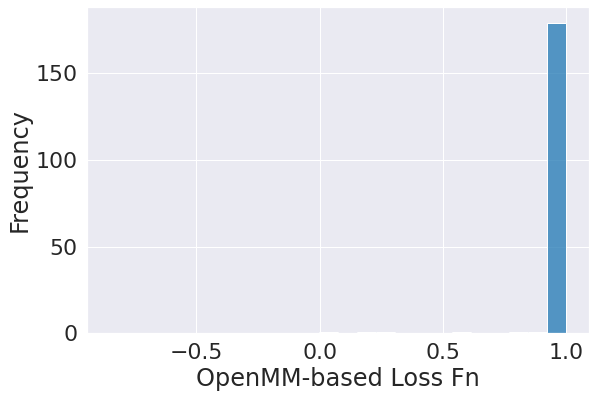

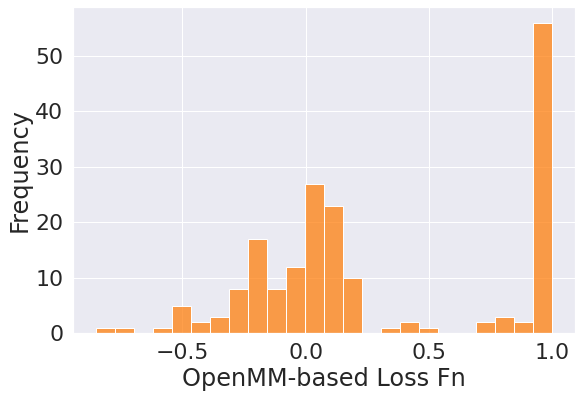

In [165]:
val_before = pd.read_csv(data_base_dirs["val"]["before"]["local-csv"])
val_after = pd.read_csv(data_base_dirs["val"]["after"]["local-csv"])

min_val = min(val_before["openmm"].min(), val_after["openmm"].min())
max_val = max(val_before["openmm"].max(), val_after["openmm"].max())
bins = np.linspace(min_val, max_val, 25)

sns.histplot(val_before["openmm"], label="before", bins=bins, color="tab:blue")
plt.xlabel("OpenMM-based Loss Fn")
plt.ylabel("Frequency")
# plt.legend()
plt.figure()

sns.histplot(val_after["openmm"], label="after", bins=bins, color="tab:orange")
plt.xlabel("OpenMM-based Loss Fn")
plt.ylabel("Frequency")
# plt.legend()
plt.show()

In [170]:
test_after["openmm"]

0    -0.068469
1    -0.354077
2    -0.146974
3     1.000000
4    -0.397157
        ...   
73    0.164046
74    1.000000
75    1.000000
76    0.057841
77   -0.026233
Name: openmm, Length: 78, dtype: float64

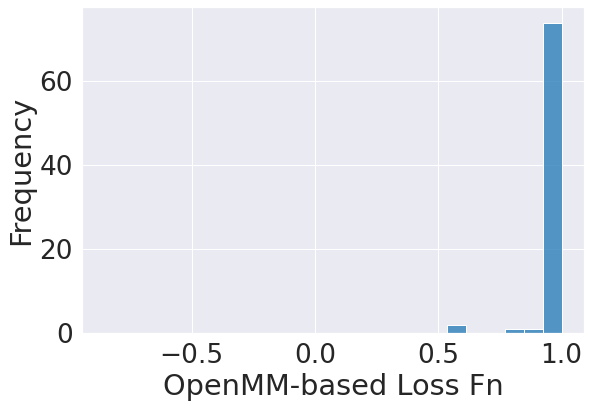

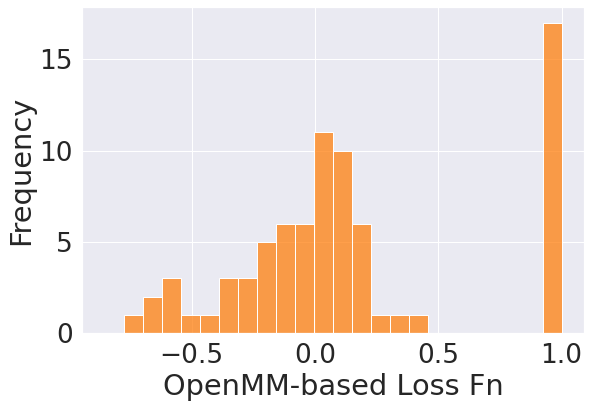

In [169]:
test_before = pd.read_csv(data_base_dirs["test"]["before"]["local-csv"])
test_after = pd.read_csv(data_base_dirs["test"]["after"]["local-csv"])

# min_val = min(test_before["openmm"].min(), test_after["openmm"].min())
# max_val = max(test_before["openmm"].max(), test_after["openmm"].max())
# bins = np.linspace(min_val, max_val, 25)

sns.histplot(test_before["openmm"], label="before", bins=bins, color="tab:blue")
plt.xlabel("OpenMM-based Loss Fn")
plt.ylabel("Frequency")
# plt.legend()
plt.savefig("test_before.svg")
plt.figure()

sns.histplot(test_after["openmm"], label="after", bins=bins, color="tab:orange")
plt.xlabel("OpenMM-based Loss Fn")
plt.ylabel("Frequency")
# plt.legend()
plt.savefig("test_after.svg")
plt.show()

In [150]:
# Now make the same figure but plot a single distribution representing the difference between the two
# Path: jk_research/230322_acs_plots_energy_comparison.ipynb
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# Specify the bins to be the same between the two histograms
import numpy as np
diff = val_after["openmm"] - val_before["openmm"]
min_val = diff.min()
max_val = diff.max()
bins = np.linspace(min_val, max_val, 50)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.histplot(diff, ax=ax, bins=bins)
ax.set_xlabel("Δ OpenMM-based Loss Fn")
ax.set_ylabel("Frequency")
plt.title("Difference in OpenMM-based Loss Fn on Validation Set\nBefore and After Training")
ax.legend()
plt.show()

KeyError: 'openmm'

# Compare Loss Fn values PT 2

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
sns.set_style("dark")
# also increase the font size dramatically, and make the plot slightly bigger
sns.set(font_scale=2)
plt.rcParams["figure.figsize"] = (9, 6)

In [141]:
energy_df_original = pd.read_csv("230322_energy.csv")
energy_df_original.head()

# Filter out rows where the abs val of energy_myh and energy are < 1e6
threshold = 1e6
energy_df = energy_df_original[(energy_df_original["energy"].abs() < threshold)]

In [142]:
val_before = energy_df[energy_df["spit"] == "val"][energy_df["version"] == "before"]
val_after = energy_df[energy_df["spit"] == "val"][energy_df["version"] == "after-complete"]

/tmp/ipykernel_415034/1539333949.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  val_before = energy_df[energy_df["spit"] == "val"][energy_df["version"] == "before"]
/tmp/ipykernel_415034/1539333949.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  val_after = energy_df[energy_df["spit"] == "val"][energy_df["version"] == "after-complete"]


In [143]:
energy_df[energy_df["spit"] == "val"]['energy'].min()

-300162.8312396171

<AxesSubplot:xlabel='version', ylabel='energy'>

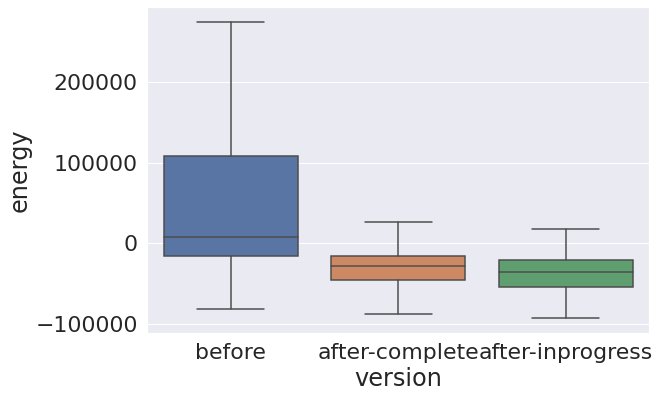

In [145]:
# energy_df['log_energy'] = np.log(energy_df['energy'])
sns.boxplot(x="version", y="energy", data=energy_df[energy_df["spit"] == "val"], showfliers=False)
# plt.yscale("log")


In [121]:
# Select the rows where the version is "before" and spit is "val"

val_before = energy_df[(energy_df["spit"].str.contains("val")) & (energy_df["version"].str.contains("before"))]
val_after = energy_df[(energy_df["spit"].str.contains("val")) & (energy_df["version"].str.contains("after-complete"))]

In [133]:
# Where the pdb entry for a row is equal, subtract the energy from the after from the energy from the before
# This will give us a list of the differences in energy between the before and after
diff = val_after.set_index("pdb").join(val_before.set_index("pdb"), lsuffix="_after", rsuffix="_before")["energy_after"] - val_after.set_index("pdb").join(val_before.set_index("pdb"), lsuffix="_after", rsuffix="_before")["energy_before"]


/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: '50' is not a valid estimator for `bins`

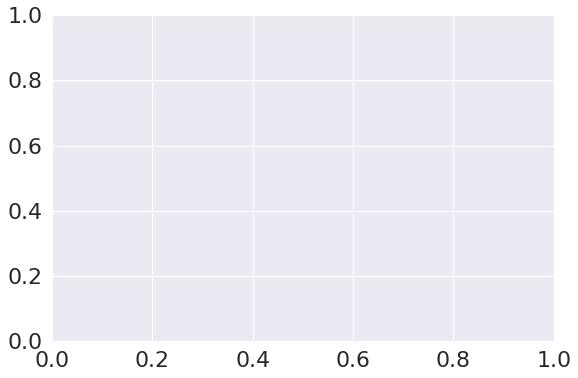

In [146]:
# Plot the differences in energy between the before and after
sns.histplot(np.log(diff), bins="50")

In [125]:
val_after

,pdb,spit,version,energy_myh,energy,log_energy
184,7nf9_A,val,after-complete,1.509968e+04,5.156395e+01,3.942823
185,7l8n_A,val,after-complete,-1.630226e+04,-2.418359e+04,NaN
186,7wbr_A,val,after-complete,-5.164692e+04,-7.589118e+04,NaN
187,7vdy_A,val,after-complete,3.251135e+06,1.971333e+06,14.494220
188,7sf6_A,val,after-complete,3.681655e+04,-4.452966e+04,NaN
...,...,...,...,...,...,...
363,7lbu_A,val,after-complete,6.157928e+05,1.091419e+05,11.600405
364,7tcb_B,val,after-complete,-1.621030e+04,-3.002255e+04,NaN
365,7b4q_A,val,after-complete,-4.570118e+04,-6.412959e+04,NaN
366,7mqy_A,val,after-complete,1.296309e+10,7.777440e+09,22.774493


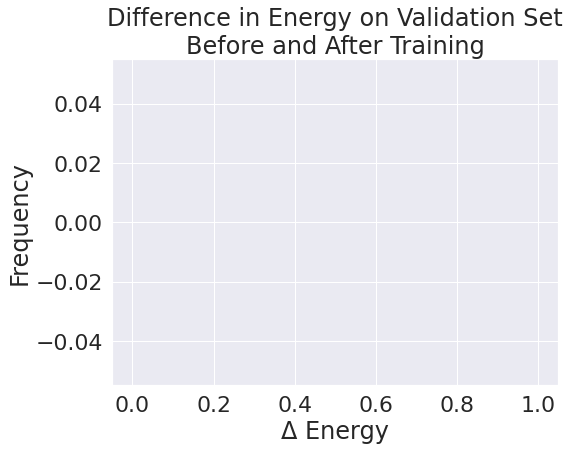

In [122]:
# Compute the change in energy and plot the difference as a histogram
diff = val_after["energy"] - val_before["energy"]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.histplot(diff, ax=ax, bins="auto")
ax.set_xlabel("Δ Energy")
ax.set_ylabel("Frequency")
plt.title("Difference in Energy on Validation Set\nBefore and After Training")
plt.show()



In [113]:
val_after['energy'], val_before['energy']

(184    5.156395e+01
 185   -2.418359e+04
 186   -7.589118e+04
 187    1.971333e+06
 188   -4.452966e+04
            ...     
 363    1.091419e+05
 364   -3.002255e+04
 365   -6.412959e+04
 366    7.777440e+09
 367   -9.327395e+04
 Name: energy, Length: 184, dtype: float64,
 0      1.607756e+06
 1      1.649481e+14
 2      1.510419e+09
 3      6.992597e+05
 4      2.042060e+06
            ...     
 179    6.114992e+07
 180    3.245686e+13
 181    2.750893e+05
 182    8.432682e+06
 183    5.841905e+04
 Name: energy, Length: 184, dtype: float64)

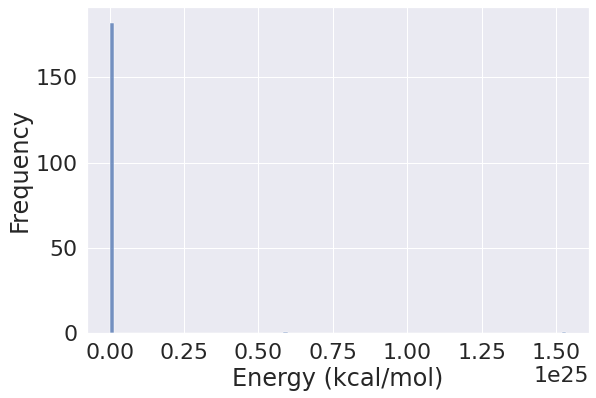

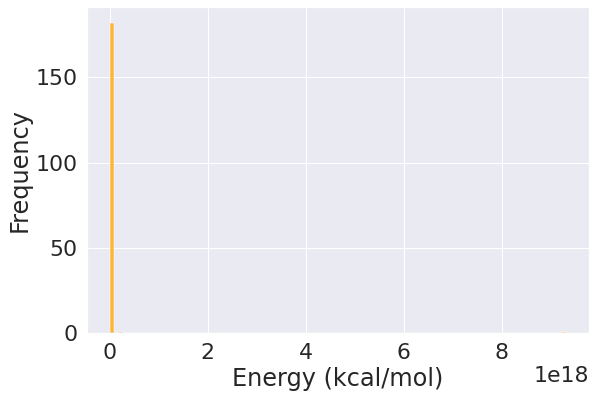

In [58]:
key = "energy"
# min_val = min(val_before[key].min(), val_after[key].min())
# max_val = max(val_before[key].max(), val_after[key].max())
# print(min_val, max_val)
# bins = np.linspace(min_val, max_val, 200)

sns.histplot(val_before[key], label="before", bins=100)
plt.xlabel("Energy (kcal/mol)") 
plt.ylabel("Frequency")
# plt.legend()
plt.figure()

sns.histplot(val_after[key], label="after", bins=100, color="orange")
plt.xlabel("Energy (kcal/mol)")
plt.ylabel("Frequency")
# plt.legend()
plt.show()

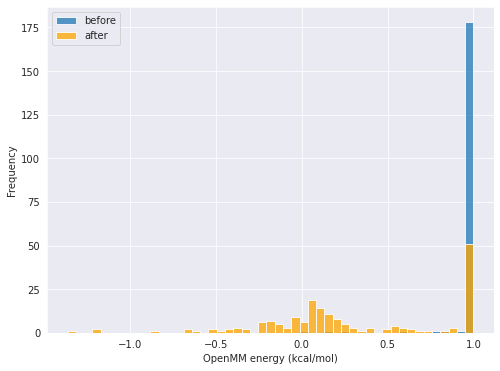

In [ ]:
# A single histogram of openmm energies from val_{before,after}['openmm']
# Path: jk_research/230322_acs_plots_energy_comparison.ipynb
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# Specify the bins to be the same between the two histograms
import numpy as np
min_val = min(val_before["openmm"].min(), val_after["openmm"].min())
max_val = max(val_before["openmm"].max(), val_after["openmm"].max())
bins = np.linspace(min_val, max_val, 50)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.histplot(val_before["openmm"], ax=ax, label="before", bins=bins)
sns.histplot(val_after["openmm"], ax=ax, label="after", bins=bins, color="orange")
ax.set_xlabel("OpenMM (kcal/mol)")
ax.set_ylabel("Frequency")
ax.legend()
plt.show()


No handles with labels found to put in legend.


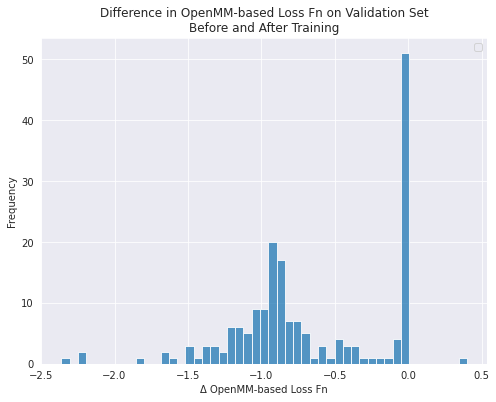

In [ ]:
# Now make the same figure but plot a single distribution representing the difference between the two
# Path: jk_research/230322_acs_plots_energy_comparison.ipynb
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# Specify the bins to be the same between the two histograms
import numpy as np
diff = val_after["openmm"] - val_before["openmm"]
min_val = diff.min()
max_val = diff.max()
bins = np.linspace(min_val, max_val, 50)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.histplot(diff, ax=ax, bins=bins)
ax.set_xlabel("Δ OpenMM-based Loss Fn")
ax.set_ylabel("Frequency")
plt.title("Difference in OpenMM-based Loss Fn on Validation Set\nBefore and After Training")
ax.legend()
plt.show()

# Compare recorded values during training

In [176]:
data_base_dirs

{'test': {'before': {'direc': '/ihome/dkoes/jok120/openfold/out/experiments/230320/validate_val_after_training/16_390/wandb/run-20230322_115143-3659ab3t',
   'csv': '',
   'local-csv': '~/acs2023/evaluation_data/test/before/val.csv',
   'local-pred-pdbs': '~/acs2023/evaluation_data/test/before/pdbs'},
  'after': {'direc': '/ihome/dkoes/jok120/openfold/out/experiments/230320/validate_val_after_training/16_390/wandb/run-20230322_114810-18trq0ov',
   'csv': '',
   'local-csv': '~/acs2023/evaluation_data/test/after/val.csv',
   'local-pred-pdbs': '~/acs2023/evaluation_data/test/after/pdbs'}},
 'val': {'before': {'direc': '/ihome/dkoes/jok120/openfold/out/experiments/230320/validate_val_initial_training_b/wandb/run-20230320_211151-36cdbdde',
   'csv': '',
   'local-csv': '~/acs2023/evaluation_data/val/before/val.csv',
   'local-pred-pdbs': '~/acs2023/evaluation_data/val/before/pdbs'},
  'after': {'direc': '/ihome/dkoes/jok120/openfold/out/experiments/230320/validate_val_after_training/16_39

In [180]:
val_before_recorded = pd.read_csv(data_base_dirs['val']['before']['local-csv'])
val_before_recorded.head()

,protein_name,distogram,experimentally_resolved,fape,plddt_loss,masked_msa,supervised_chi,violation,openmm_scaled,openmm,...,rmsd_ca,gdtts_ca,gdtha_ca,rmsd_aa,gdcall_aa,tmscore_aa,tmscore_ca,drmsd_aa,lddt_aa,lddtquasi_aa
0,7au7_A,1.006745,0.693147,0.432176,1.962513,0.361442,0.324099,0.314364,0.000100,1.000000,...,0.838434,0.950739,0.816502,1.536673,0.779447,0.987356,0.977510,1.205491,0.855667,0.856091
1,7f8a_A,0.679438,0.693147,0.384490,1.571567,0.590973,0.195727,0.132499,0.000100,1.000000,...,1.199704,0.900000,0.725510,1.471000,0.745541,0.989085,0.966189,0.948522,0.912355,0.912630
2,7vmu_A,0.952823,0.693147,0.440878,1.981733,0.375211,0.353823,0.284124,0.000100,1.000000,...,0.899820,0.936364,0.768182,1.376992,0.751888,0.989275,0.975896,1.018882,0.857419,0.857836
3,6wmk_A,1.980916,0.693147,0.456639,2.595275,0.000025,0.422177,0.211192,0.000100,1.000000,...,1.066982,0.915385,0.742308,2.682809,0.657157,0.934662,0.897713,1.986710,0.720829,0.721898
4,7mpz_A,0.950167,0.693147,0.309782,1.400970,0.773024,0.196442,0.048816,0.000081,0.806038,...,1.258024,0.902174,0.730072,1.668609,0.707855,0.980229,0.940816,1.385770,0.903370,0.903698


In [181]:
val_after_recorded = pd.read_csv(data_base_dirs['val']['after']['local-csv'])

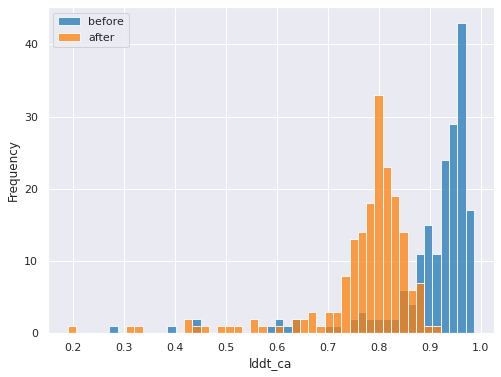

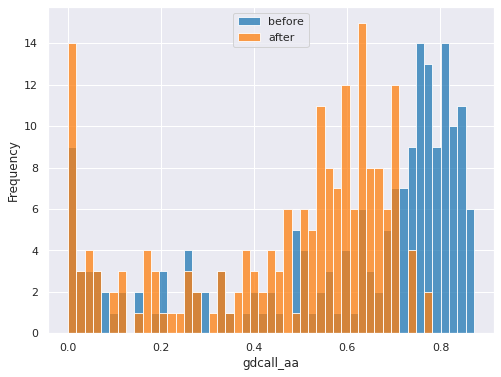

In [187]:
# Compare the lddt_calculated values from the before and after using histograms
# Path: jk_research/230322_acs_plots_energy_comparison.ipynb
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
# make the font size normal
sns.set(font_scale=1.0)

# Specify the bins to be the same between the two histograms
import numpy as np
min_val = min(val_before_recorded["lddt_ca"].min(), val_after_recorded["lddt_ca"].min())
max_val = max(val_before_recorded["lddt_ca"].max(), val_after_recorded["lddt_ca"].max())
bins = np.linspace(min_val, max_val, 50)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.histplot(val_before_recorded["lddt_ca"], ax=ax, label="before", bins=bins, color="tab:blue")
sns.histplot(val_after_recorded["lddt_ca"], ax=ax, label="after", bins=bins, color="tab:orange")
ax.set_ylabel("Frequency")
ax.legend()
plt.show()

# Repeat but for gdcall_aa
# Path: jk_research/230322_acs_plots_energy_comparison.ipynb
import matplotlib.pyplot as plt

# Specify the bins to be the same between the two histograms
import numpy as np
min_val = min(val_before_recorded["gdcall_aa"].min(), val_after_recorded["gdcall_aa"].min())
max_val = max(val_before_recorded["gdcall_aa"].max(), val_after_recorded["gdcall_aa"].max())
bins = np.linspace(min_val, max_val, 50)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.histplot(val_before_recorded["gdcall_aa"], ax=ax, label="before", bins=bins, color="tab:blue")
sns.histplot(val_after_recorded["gdcall_aa"], ax=ax, label="after", bins=bins, color="tab:orange")
ax.set_ylabel("Frequency")
ax.legend()
plt.show()
